In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import random
random.seed(108448)
from scipy.stats import poisson

#%pip install gurobipy
import gurobipy as gp
from gurobipy import GRB

#Data generation

In [232]:
#Define the number of elememts in each set I, J, K
i_num = 25
k_num = 1
j_num = 1000 #Without I and K, so real j_num_real = j_num + i_num + k_num

#Define empty data frames
I = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longtitude'])
J = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longtitude'])
K = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longtitude'])


In [233]:
#Define sets of I, J, K, where J contains I and K

for i in range(i_num):
    I.loc[i, 'Point number'] = 'i'+ str(i)
    I.loc[i, 'Latitude'] = round(random.uniform(0, 100), 4)
    I.loc[i, 'Longtitude'] = round(random.uniform(0, 100), 4)

I.index = I['Point number']
    
    
for k in range(k_num):
    K.loc[k, 'Point number'] = 'k'+ str(k)
    K.loc[k, 'Latitude'] = round(random.uniform(0, 100), 4)
    K.loc[k, 'Longtitude'] = round(random.uniform(0, 100), 4)

K.index = K['Point number']


for j in range(j_num):
    J.loc[j, 'Point number'] = 'j'+ str(j)
    J.loc[j, 'Latitude'] = round(random.uniform(0, 100), 4)
    J.loc[j, 'Longtitude'] = round(random.uniform(0, 100), 4)

J.index = J['Point number'] 
J = pd.concat([J, K, I], axis = 0) #Include K to J
I.index

Index(['i0', 'i1', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7', 'i8', 'i9', 'i10',
       'i11', 'i12', 'i13', 'i14', 'i15', 'i16', 'i17', 'i18', 'i19', 'i20',
       'i21', 'i22', 'i23', 'i24'],
      dtype='object', name='Point number')

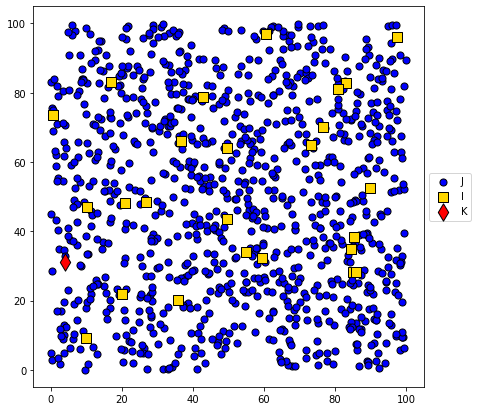

In [234]:
axs, fig = plt.subplots(1, 1, figsize = (7, 7))

fig.scatter(J['Latitude'], J['Longtitude'], color = 'blue', edgecolors = 'black',
            marker = 'o', s = 50, label = 'J')
fig.scatter(I['Latitude'], I['Longtitude'], color = 'gold', edgecolors = 'black',
            marker = 's', s = 100, label = 'I')
fig.scatter(K['Latitude'], K['Longtitude'], color = 'red', edgecolors = 'black',
            marker = 'd', s = 150, label = 'K')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [235]:
#Define constants

B = 100
S = 10
alpha = 10

beta = {}
for j in J.index:
    if j.startswith('j'):
        beta[j] = 400
    else:
        beta[j] = 300
        
q_j = {j: 50 for j in J.index}
up_bound = 12
mu = {i : int(round(random.uniform(0, up_bound), 0)) for i in I.index}

mu

{'i0': 2,
 'i1': 5,
 'i2': 1,
 'i3': 3,
 'i4': 3,
 'i5': 4,
 'i6': 12,
 'i7': 7,
 'i8': 2,
 'i9': 2,
 'i10': 3,
 'i11': 6,
 'i12': 4,
 'i13': 9,
 'i14': 0,
 'i15': 11,
 'i16': 3,
 'i17': 1,
 'i18': 10,
 'i19': 10,
 'i20': 10,
 'i21': 11,
 'i22': 8,
 'i23': 12,
 'i24': 3}

Deterministic model

In [236]:
theta_det = {}
for n in I.index:
    theta_det[n] = list(poisson.rvs(mu[n], size = 1))[0]
theta_det

{'i0': 2,
 'i1': 3,
 'i2': 0,
 'i3': 3,
 'i4': 5,
 'i5': 4,
 'i6': 15,
 'i7': 11,
 'i8': 1,
 'i9': 1,
 'i10': 5,
 'i11': 3,
 'i12': 3,
 'i13': 8,
 'i14': 0,
 'i15': 14,
 'i16': 3,
 'i17': 2,
 'i18': 12,
 'i19': 12,
 'i20': 13,
 'i21': 4,
 'i22': 7,
 'i23': 15,
 'i24': 3}

In [237]:
#Define distance matrices

def distance(point1, PointsSet1, point2, PointsSet2):
    c1 = np.array((PointsSet1.loc[point1, 'Latitude'], PointsSet1.loc[point1, 'Longtitude']))
    c2 = np.array((PointsSet2.loc[point2, 'Latitude'], PointsSet2.loc[point2, 'Longtitude']))
    return np.linalg.norm(c1-c2)

dist_JI = {(c1, c2): distance(c1, J, c2, I)for c1, c2 in itertools.product(J.index, I.index)}
dist_IK = {(c1, c2): distance(c1, I, c2, K)for c1, c2 in itertools.product(I.index, K.index)}
dist_KJ = {(c1, c2): distance(c1, K, c2, J)for c1, c2 in itertools.product(K.index, J.index)}
 
dist_KJ


{('k0', 'j0'): 85.99466330604474,
 ('k0', 'j1'): 89.8268627047611,
 ('k0', 'j2'): 63.26521610569271,
 ('k0', 'j3'): 74.33557988641778,
 ('k0', 'j4'): 18.60344138109936,
 ('k0', 'j5'): 86.39629248648347,
 ('k0', 'j6'): 48.486317080595015,
 ('k0', 'j7'): 74.448788525066,
 ('k0', 'j8'): 71.07218370565238,
 ('k0', 'j9'): 65.27558283592725,
 ('k0', 'j10'): 40.72400689924802,
 ('k0', 'j11'): 25.92775521810556,
 ('k0', 'j12'): 89.82071903130146,
 ('k0', 'j13'): 87.57952999674067,
 ('k0', 'j14'): 43.78252601438158,
 ('k0', 'j15'): 60.30676968052592,
 ('k0', 'j16'): 18.09897645420867,
 ('k0', 'j17'): 94.3925343315879,
 ('k0', 'j18'): 90.6023735941835,
 ('k0', 'j19'): 66.83373440419142,
 ('k0', 'j20'): 91.85778268589982,
 ('k0', 'j21'): 17.104134071036743,
 ('k0', 'j22'): 64.33988442676906,
 ('k0', 'j23'): 79.17505449906555,
 ('k0', 'j24'): 44.92000494312084,
 ('k0', 'j25'): 72.21586230988314,
 ('k0', 'j26'): 46.00592496766042,
 ('k0', 'j27'): 31.00885082053187,
 ('k0', 'j28'): 57.74419812327468

In [238]:
#Define set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= 0.5*B:
        L.append((k, j))
        
L

[('k0', 'j4'),
 ('k0', 'j6'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j14'),
 ('k0', 'j16'),
 ('k0', 'j21'),
 ('k0', 'j24'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j31'),
 ('k0', 'j33'),
 ('k0', 'j38'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j46'),
 ('k0', 'j49'),
 ('k0', 'j51'),
 ('k0', 'j53'),
 ('k0', 'j55'),
 ('k0', 'j57'),
 ('k0', 'j63'),
 ('k0', 'j65'),
 ('k0', 'j67'),
 ('k0', 'j72'),
 ('k0', 'j74'),
 ('k0', 'j75'),
 ('k0', 'j76'),
 ('k0', 'j77'),
 ('k0', 'j78'),
 ('k0', 'j79'),
 ('k0', 'j80'),
 ('k0', 'j82'),
 ('k0', 'j86'),
 ('k0', 'j96'),
 ('k0', 'j97'),
 ('k0', 'j98'),
 ('k0', 'j101'),
 ('k0', 'j102'),
 ('k0', 'j104'),
 ('k0', 'j107'),
 ('k0', 'j108'),
 ('k0', 'j113'),
 ('k0', 'j119'),
 ('k0', 'j120'),
 ('k0', 'j121'),
 ('k0', 'j124'),
 ('k0', 'j125'),
 ('k0', 'j126'),
 ('k0', 'j134'),
 ('k0', 'j139'),
 ('k0', 'j142'),
 ('k0', 'j152'),
 ('k0', 'j153'),
 ('k0', 'j154'),
 ('k0', 'j163'),
 ('k0', 'j169'),
 ('k0', 'j170'),
 ('k0', 'j171'),
 ('k0', 'j172'),
 ('k0', 'j174'),
 (

In [239]:
#Define sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_interim = {key : val for key, val in M_kj.items() if val != []}  

KJ_feas = list(M_kj_interim.keys())
KJ_feas


[('k0', 'j4'),
 ('k0', 'j11'),
 ('k0', 'j16'),
 ('k0', 'j21'),
 ('k0', 'j24'),
 ('k0', 'j27'),
 ('k0', 'j33'),
 ('k0', 'j38'),
 ('k0', 'j46'),
 ('k0', 'j51'),
 ('k0', 'j65'),
 ('k0', 'j76'),
 ('k0', 'j77'),
 ('k0', 'j79'),
 ('k0', 'j80'),
 ('k0', 'j82'),
 ('k0', 'j86'),
 ('k0', 'j98'),
 ('k0', 'j101'),
 ('k0', 'j104'),
 ('k0', 'j108'),
 ('k0', 'j120'),
 ('k0', 'j121'),
 ('k0', 'j124'),
 ('k0', 'j126'),
 ('k0', 'j134'),
 ('k0', 'j139'),
 ('k0', 'j142'),
 ('k0', 'j152'),
 ('k0', 'j153'),
 ('k0', 'j163'),
 ('k0', 'j178'),
 ('k0', 'j181'),
 ('k0', 'j190'),
 ('k0', 'j192'),
 ('k0', 'j194'),
 ('k0', 'j203'),
 ('k0', 'j205'),
 ('k0', 'j207'),
 ('k0', 'j218'),
 ('k0', 'j226'),
 ('k0', 'j230'),
 ('k0', 'j235'),
 ('k0', 'j246'),
 ('k0', 'j251'),
 ('k0', 'j252'),
 ('k0', 'j254'),
 ('k0', 'j258'),
 ('k0', 'j263'),
 ('k0', 'j268'),
 ('k0', 'j274'),
 ('k0', 'j293'),
 ('k0', 'j296'),
 ('k0', 'j310'),
 ('k0', 'j324'),
 ('k0', 'j335'),
 ('k0', 'j339'),
 ('k0', 'j340'),
 ('k0', 'j349'),
 ('k0', 'j350'),

In [240]:
#Define sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i_interim = {key : val for key, val in N_i.items() if val != []}   
 
I_feas = list(N_i_interim.keys())

In [241]:
model_det = gp.Model('Deterministic model')

x_ikj = model_det.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_det.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')

In [242]:
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) >= theta_det[i] for i in I_feas), name = 'c2')
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c4')
model_det.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c5')
model_det.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c6')

{('k0', 'j349', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j413', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j449', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j559', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j591', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j641', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j691', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j712', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j742', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j839', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j916', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j918', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'i24', 'i24'): <gurobi.Constr *Awaiting Model Update*>}

In [243]:
model_det.setObjective(alpha * gp.quicksum(x_ikj) + gp.quicksum(beta[j] * y_j[j] for j in J.index), GRB.MINIMIZE)
model_det.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 215 rows, 10026 columns and 641 nonzeros
Model fingerprint: 0x14aa993b
Variable types: 0 continuous, 10026 integer (1026 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 3860.0000000
Presolve removed 130 rows and 9854 columns
Presolve time: 0.01s
Presolved: 85 rows, 172 columns, 262 nonzeros
Found heuristic solution: objective 3060.0000000
Variable types: 0 continuous, 172 integer (82 binary)

Root relaxation: objective 2.437778e+03, 92 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntIn

In [244]:
def ListSolution(model):
        nSolutions = model.SolCount
        print('Number of solutions found: ' + str(nSolutions))
        for e in range(nSolutions):
        #for iter2 in range(1):
                model.setParam(GRB.Param.SolutionNumber, e)
                print(e)
                print('%g ' % model.PoolObjVal, end='\n')
                for v in model.getVars():
                        if v.X > 0:
                                print ('%s %g' % (v.varName, v.X))
                                #print(v)
                print("\n")
                
        print("\n")
        
ListSolution(model_det)

Number of solutions found: 4
0
2560 
x_ikj[i6,k0,j953] 15
x_ikj[i8,k0,i8] 1
x_ikj[i15,k0,i15] 14
x_ikj[i17,k0,i22] 2
x_ikj[i18,k0,j953] 12
x_ikj[i19,k0,i19] 12
x_ikj[i22,k0,i22] 7
x_ikj[i24,k0,i24] 3
y_j[j953] 1
y_j[i8] 1
y_j[i15] 1
y_j[i19] 1
y_j[i22] 1
y_j[i24] 1


1
2660 
x_ikj[i6,k0,j953] 15
x_ikj[i8,k0,i8] 1
x_ikj[i15,k0,i15] 14
x_ikj[i17,k0,i22] 2
x_ikj[i18,k0,j953] 12
x_ikj[i19,k0,i19] 12
x_ikj[i22,k0,i22] 7
x_ikj[i24,k0,i24] 3
y_j[j953] 1
y_j[i8] 1
y_j[i15] 1
y_j[i19] 1
y_j[i22] 1
y_j[i24] 1


2
3060 
x_ikj[i6,k0,j953] 15
x_ikj[i8,k0,i8] 1
x_ikj[i15,k0,i15] 14
x_ikj[i17,k0,i22] 2
x_ikj[i18,k0,j953] 12
x_ikj[i19,k0,i19] 12
x_ikj[i22,k0,i22] 7
x_ikj[i24,k0,i24] 3
y_j[j953] 1
y_j[i8] 1
y_j[i15] 1
y_j[i19] 1
y_j[i22] 1
y_j[i24] 1


3
3860 
x_ikj[i6,k0,j953] 15
x_ikj[i8,k0,i8] 1
x_ikj[i15,k0,i15] 14
x_ikj[i17,k0,i22] 2
x_ikj[i18,k0,j953] 12
x_ikj[i19,k0,i19] 12
x_ikj[i22,k0,i22] 7
x_ikj[i24,k0,i24] 3
y_j[j953] 1
y_j[i8] 1
y_j[i15] 1
y_j[i19] 1
y_j[i22] 1
y_j[i24] 1






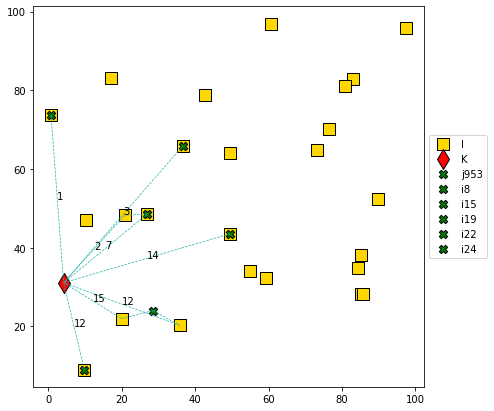

In [245]:
def SolutionGraph(I, K, J, model):
        
        axs, fig = plt.subplots(1, 1, figsize = (7, 7))
                
        fig.scatter(I['Latitude'], I['Longtitude'], color = 'gold', edgecolors = 'black',
                                marker = 's', s = 150, label = 'I')
        fig.scatter(K['Latitude'], K['Longtitude'], color = 'red', edgecolors = 'black',
                                marker = 'd', s = 200, label = 'K')
       
        model.setParam(GRB.Param.SolutionNumber, 0)
        for v in model.getVars():
                if v.xn > 0:
                        if v.varName.startswith('x_ikj'):
                                indices_x = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                                fig.plot((J.loc[indices_x[2], 'Latitude'], I.loc[indices_x[0], 'Latitude']),
                                        (J.loc[indices_x[2], 'Longtitude'], I.loc[indices_x[0], 'Longtitude']),
                                        color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                fig.plot((I.loc[indices_x[0], 'Latitude'], K.loc[indices_x[1], 'Latitude']),
                                        (I.loc[indices_x[0], 'Longtitude'], K.loc[indices_x[1], 'Longtitude']),
                                        color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                fig.annotate(str(int(v.xn)), xy = ((K.loc[indices_x[1], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2,
                                                                (K.loc[indices_x[1], 'Longtitude'] + I.loc[indices_x[0], 'Longtitude'])/2))
                                #fig.annotate(str(int(v.xn)), xy = ((J.loc[indices_x[2], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2,
                                                                #(J.loc[indices_x[2], 'Longtitude'] + I.loc[indices_x[0], 'Longtitude'])/2))
                        else:
                                index_y = v.varName[4:-1]
                                fig.scatter(J.loc[index_y, 'Latitude'], J.loc[index_y, 'Longtitude'], color = 'green',
                                        edgecolors = 'black', s = 70, marker = 'X', label = index_y)
                fig.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
    

SolutionGraph(I, K, J, model_det)

In [246]:
for v in model_det.getVars():
        if v.xn > 0:
            if v.varName.startswith('x_ikj'):
                indices_x = v.varName[6:-1].split(',')
indices_x

['i24', 'k0', 'i24']

Probabilistic model

In [247]:
#Define constants and random variables

theta_ran_i = {}
for n in list(I.index):
    theta_ran_i[n] = poisson(mu[n])

p = 0.99

l_i = {}
for i in theta_ran_i.keys():
    l_i[i] = int(theta_ran_i[i].ppf(p))

g_i = {}
for i in theta_ran_i.keys():
    g_i[i] = up_bound * 4

IG = []
for i in I.index:
    for g in range(1, g_i[i] + 1):
        IG.append((i, g))

I_feasG = []
for i in I_feas:
    for g in range(1, g_i[i] + 1):
        I_feasG.append((i, g))
        

h_ig = {}
for (i, g) in IG:
    h_ig[(i, g)] = math.log(theta_ran_i[i].cdf(l_i[i] + g)) - math.log(theta_ran_i[i].cdf(l_i[i] + g - 1))


phi = float(math.log(p) - sum(theta_ran_i[i].cdf(l_i[i]) for i in I_feas))

In [248]:
model_prob = gp.Model('Probabilistic model without relaxation')

x_ikj = model_prob.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_prob.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')
z_ig = model_prob.addVars(IG, vtype = GRB.BINARY, name = 'z_ig')

In [249]:
#Probabilistic constraints

model_prob.addConstr((gp.quicksum(h_ig[ig] * z_ig[ig] for ig in I_feasG)) >= phi, name = 'c15')
model_prob.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) == l_i[i] + gp.quicksum(z_ig) for (i, g) in I_feasG), name = 'c16')

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


{('i2', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 2): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 3): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 4): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 5): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 6): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 7): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 9): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 10): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 11): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 12): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 13): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 14): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 15): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 16): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 17): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 18): <gurobi.Constr *Awaiting Model Update*>,
 ('i2', 19): <gurobi.Constr *Awaiting

In [250]:
#Same constraints as in the deterministic model

model_prob.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c17')
model_prob.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c18')
model_prob.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c19')

{('k0', 'j349', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j413', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j449', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j559', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j591', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j641', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j691', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j712', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j742', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j839', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j916', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j918', 'i24'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'i24', 'i24'): <gurobi.Constr *Awaiting Model Update*>}

In [251]:
model_prob.setObjective(alpha * gp.quicksum(x_ikj) + gp.quicksum(beta[j] * y_j[j] for j in J.index), GRB.MINIMIZE)
model_prob.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)



CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 639 rows, 11226 columns and 529452 nonzeros
Model fingerprint: 0x295bc7d2
Variable types: 0 continuous, 11226 integer (2226 binary)
Coefficient statistics:
  Matrix range     [1e-13, 1e+02]
  Objective range  [1e+01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 1e+02]
Found heuristic solution: objective 4730.0000000
Presolve removed 450 rows and 10827 columns
Presolve time: 0.25s
Presolved: 189 rows, 399 columns, 625 nonzeros
Variable types: 0 continuous, 399 integer (180 binary)

Root relaxation: objective 1.808000e+03, 225 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1808.00000    0    8 4730.00000 1808.0000

In [252]:
ListSolution(model_prob)

Number of solutions found: 3
0
3130 
x_ikj[i2,k0,j79] 4
x_ikj[i6,k0,j684] 21
x_ikj[i8,k0,i8] 6
x_ikj[i15,k0,i15] 19
x_ikj[i17,k0,j79] 4
x_ikj[i18,k0,j684] 18
x_ikj[i19,k0,i19] 18
x_ikj[i22,k0,j79] 15
x_ikj[i24,k0,i24] 8
y_j[j79] 1
y_j[j684] 1
y_j[i8] 1
y_j[i15] 1
y_j[i19] 1
y_j[i24] 1


1
3530 
x_ikj[i2,k0,j79] 4
x_ikj[i6,k0,j684] 21
x_ikj[i8,k0,i8] 6
x_ikj[i15,k0,i15] 19
x_ikj[i17,k0,j79] 4
x_ikj[i18,k0,j684] 18
x_ikj[i19,k0,i19] 18
x_ikj[i22,k0,j79] 15
x_ikj[i24,k0,i24] 8
y_j[j79] 1
y_j[j684] 1
y_j[i8] 1
y_j[i15] 1
y_j[i19] 1
y_j[i24] 1


2
4730 
x_ikj[i2,k0,j79] 4
x_ikj[i6,k0,j684] 21
x_ikj[i8,k0,i8] 6
x_ikj[i15,k0,i15] 19
x_ikj[i17,k0,j79] 4
x_ikj[i18,k0,j684] 18
x_ikj[i19,k0,i19] 18
x_ikj[i22,k0,j79] 15
x_ikj[i24,k0,i24] 8
y_j[j79] 1
y_j[j684] 1
y_j[i8] 1
y_j[i15] 1
y_j[i19] 1
y_j[i24] 1






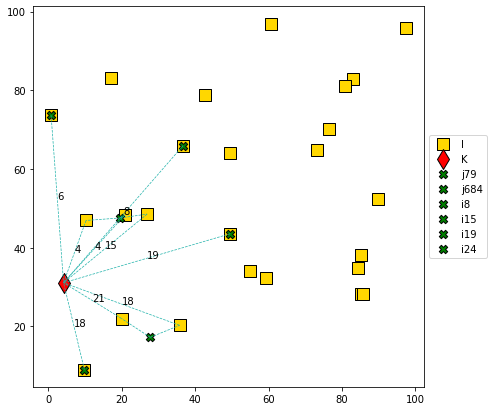

In [253]:
SolutionGraph(I, K, J, model_prob)

Probabilistic model with relaxed constraints

In [254]:
#Redefine set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= B:
        L.append((k, j))
        
L

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 ('k0', 'j63'),
 ('k0', 'j64'),
 ('k0', 'j65'),
 (

In [255]:
#Redefine sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_interim = {key : val for key, val in M_kj.items() if val != []}  

KJ_feas = list(M_kj_interim.keys())
KJ_feas

[('k0', 'j4'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j29'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j64'),
 ('k0', 'j65'),
 ('k0', 'j68'),
 ('k0', 'j69'),
 ('k0', 'j72'),
 ('k0', 'j76'),
 ('k0', 'j77'),
 ('k0', 'j79'),
 ('k0', 'j80'),
 ('k0', 'j81'),
 ('k0', 'j82'),
 ('k0', 'j84'),
 ('k0', 'j86'),
 ('k0', 'j87'),
 ('k0', 'j90'),
 ('k0', 'j94'),
 ('k0', 'j95'),
 ('k0', 'j96'),
 ('k0', 'j98'),
 ('k0', 'j101'),
 ('k0', 'j102'),
 ('k0', 'j103'),
 ('k0', 'j104'),
 ('k0', 'j105'),
 ('k0', 'j106'),
 ('k0', 'j108'),
 ('k0', 'j109'),
 ('k0', 'j111'),
 (

In [256]:
#Redefine sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i_interim = {key : val for key, val in N_i.items() if val != []}   
 
I_feas = list(N_i_interim.keys())

In [257]:
#Redefine constants and random variables


I_feasG = []
for i in I_feas:
    for g in range(1, g_i[i] + 1):
        I_feasG.append((i, g))

In [258]:
model_prob_rel = gp.Model('Probabilistic model with relaxation')

x_ikj = model_prob_rel.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_prob_rel.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')
z_ig = model_prob_rel.addVars(IG, vtype = GRB.BINARY, name = 'z_ig')

In [259]:
model_prob_rel.addConstr((gp.quicksum(h_ig[ig] * z_ig[ig] for ig in I_feasG)) >= phi, name = 'c15')
model_prob_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) == l_i[i] + gp.quicksum(z_ig) for (i, g) in I_feasG), name = 'c16')
model_prob_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c17')
model_prob_rel.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c18')
model_prob_rel.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c19')


model_prob_rel.setObjective(alpha * gp.quicksum(x_ikj) + gp.quicksum(beta[j] * y_j[j] for j in J.index), GRB.MINIMIZE)
model_prob_rel.optimize()

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1802 rows, 27001 columns and 1421534 nonzeros
Model fingerprint: 0x09569214
Variable types: 0 continuous, 27001 integer (2226 binary)
Coefficient statistics:
  Matrix range     [1e-13, 1e+02]
  Objective range  [1e+01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 1e+02]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 11600.000000
Presolve removed 1262 rows and 25747 columns
Presolve time: 0.71s
Presolved: 540 rows, 1254 columns, 2014 nonzeros
Variable types: 0 continuous, 1254 integer (516 binary)

Root relaxation: objective 4.320000e+03, 754

In [260]:
ListSolution(model_prob_rel)

Number of solutions found: 7
0
6900 
x_ikj[i0,k0,j95] 6
x_ikj[i1,k0,j674] 11
x_ikj[i2,k0,j536] 4
x_ikj[i3,k0,i3] 8
x_ikj[i4,k0,j95] 8
x_ikj[i5,k0,i3] 9
x_ikj[i6,k0,j702] 21
x_ikj[i7,k0,i7] 14
x_ikj[i8,k0,j113] 6
x_ikj[i9,k0,j113] 6
x_ikj[i10,k0,j455] 8
x_ikj[i11,k0,j674] 12
x_ikj[i12,k0,i12] 9
x_ikj[i15,k0,j674] 19
x_ikj[i16,k0,j455] 8
x_ikj[i17,k0,j536] 4
x_ikj[i18,k0,j702] 18
x_ikj[i19,k0,i19] 18
x_ikj[i20,k0,i21] 18
x_ikj[i21,k0,i21] 19
x_ikj[i22,k0,j536] 15
x_ikj[i23,k0,j95] 21
x_ikj[i24,k0,i24] 8
y_j[j95] 1
y_j[j113] 1
y_j[j455] 1
y_j[j536] 1
y_j[j674] 1
y_j[j702] 1
y_j[i3] 1
y_j[i7] 1
y_j[i12] 1
y_j[i19] 1
y_j[i21] 1
y_j[i24] 1


1
7200 
x_ikj[i0,k0,j95] 6
x_ikj[i1,k0,j674] 11
x_ikj[i2,k0,j536] 4
x_ikj[i3,k0,i3] 8
x_ikj[i4,k0,j95] 8
x_ikj[i5,k0,i3] 9
x_ikj[i6,k0,j702] 21
x_ikj[i7,k0,i7] 14
x_ikj[i8,k0,j113] 6
x_ikj[i9,k0,j113] 6
x_ikj[i10,k0,j455] 8
x_ikj[i11,k0,j674] 12
x_ikj[i12,k0,i12] 9
x_ikj[i15,k0,j674] 19
x_ikj[i16,k0,j455] 8
x_ikj[i17,k0,j536] 4
x_ikj[i18,k0,j702] 18
x_ik

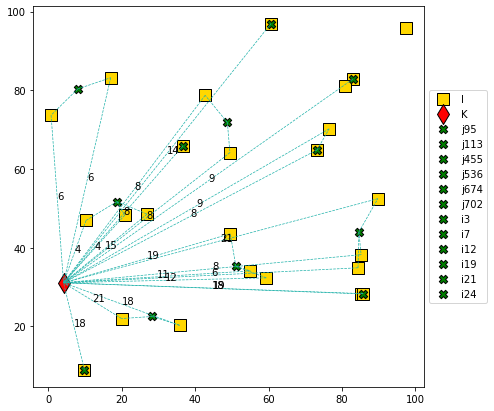

In [261]:
SolutionGraph(I, K, J, model_prob_rel)

In [264]:
model_det_rel = gp.Model('Deterministic model with relaxation')

x_ikj = model_det_rel.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_det_rel.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')

In [265]:
model_det_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) >= theta_det[i] for i in I_feas), name = 'c2')
model_det_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c4')
model_det_rel.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c5')
model_det_rel.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c6')

model_det_rel.setObjective(alpha * gp.quicksum(x_ikj) + gp.quicksum(beta[j] * y_j[j] for j in J.index), GRB.MINIMIZE)
model_det_rel.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 673 rows, 25801 columns and 2202 nonzeros
Model fingerprint: 0x7bcf0ac3
Variable types: 0 continuous, 25801 integer (1026 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 9710.0000000
Presolve removed 576 rows and 25509 columns
Presolve time: 0.06s
Presolved: 97 rows, 292 columns, 492 nonzeros
Found heuristic solution: objective 6410.0000000
Variable types: 0 continuous, 292 integer (92 binary)

Root relaxation: objective 5.382727e+03, 146 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth In

In [266]:
ListSolution(model_det_rel)

Number of solutions found: 5
0
5410 
x_ikj[i0,k0,i20] 2
x_ikj[i1,k0,j199] 3
x_ikj[i3,k0,i5] 3
x_ikj[i4,k0,i20] 5
x_ikj[i5,k0,i5] 4
x_ikj[i6,k0,j831] 15
x_ikj[i7,k0,i7] 11
x_ikj[i8,k0,j113] 1
x_ikj[i9,k0,j113] 1
x_ikj[i10,k0,j455] 5
x_ikj[i11,k0,j199] 3
x_ikj[i12,k0,i12] 3
x_ikj[i15,k0,j199] 14
x_ikj[i16,k0,j455] 3
x_ikj[i17,k0,i22] 2
x_ikj[i18,k0,j831] 12
x_ikj[i19,k0,i19] 12
x_ikj[i20,k0,i20] 13
x_ikj[i21,k0,i20] 4
x_ikj[i22,k0,i22] 7
x_ikj[i23,k0,i23] 15
x_ikj[i24,k0,i24] 3
y_j[j113] 1
y_j[j199] 1
y_j[j455] 1
y_j[j831] 1
y_j[i5] 1
y_j[i7] 1
y_j[i12] 1
y_j[i19] 1
y_j[i20] 1
y_j[i22] 1
y_j[i23] 1
y_j[i24] 1


1
5510 
x_ikj[i0,k0,i20] 2
x_ikj[i1,k0,j199] 3
x_ikj[i3,k0,i5] 3
x_ikj[i4,k0,i20] 5
x_ikj[i5,k0,i5] 4
x_ikj[i6,k0,j831] 15
x_ikj[i7,k0,i7] 11
x_ikj[i8,k0,j113] 1
x_ikj[i9,k0,j113] 1
x_ikj[i10,k0,j455] 5
x_ikj[i11,k0,j199] 3
x_ikj[i12,k0,i12] 3
x_ikj[i15,k0,j199] 14
x_ikj[i16,k0,j455] 3
x_ikj[i17,k0,i22] 2
x_ikj[i18,k0,j831] 12
x_ikj[i19,k0,i19] 12
x_ikj[i20,k0,i20] 13
x_ikj[i21,k0

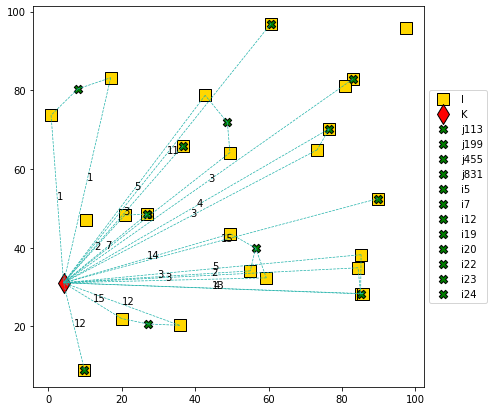

In [267]:
SolutionGraph(I, K, J, model_det_rel)

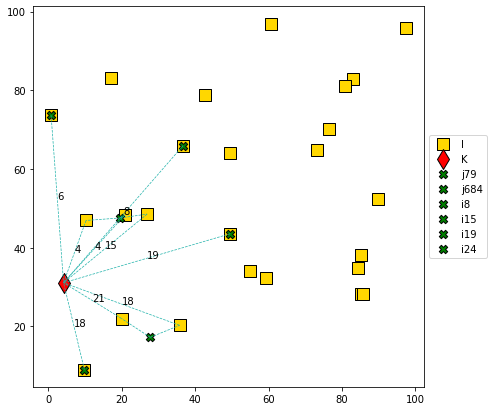

In [262]:
SolutionGraph(I, K, J, model_prob)

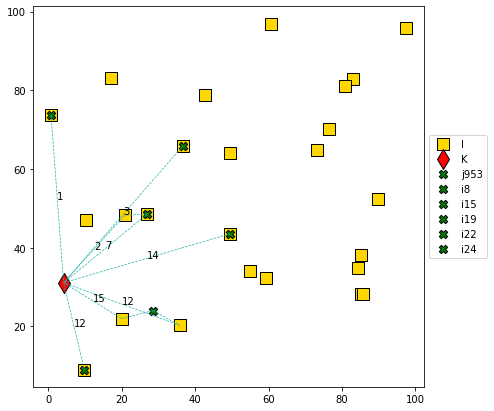

In [263]:
SolutionGraph(I, K, J, model_det)

1) complete information optimum - lower bound for optimum
2) price of uncertainty